In [217]:
# Initialization

In [218]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [219]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 30

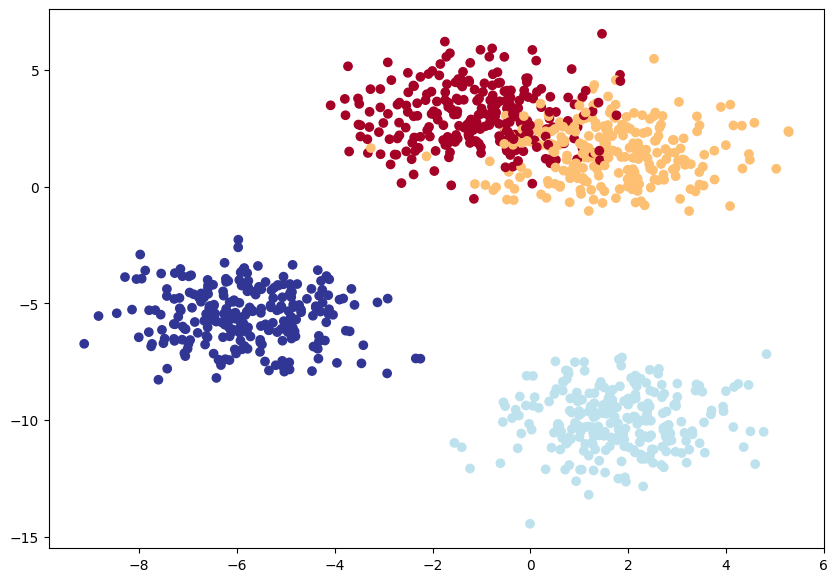

In [220]:
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.2,
)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [221]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_train, X_test, Y_train, Y_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
)

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

tensor([[  2.7314, -12.0245],
        [  1.8759,   2.6451],
        [  3.1369,   2.0640],
        [  0.8822,   0.8760],
        [  2.2945, -10.0027]]) tensor([2, 1, 1, 1, 2])


In [222]:
# Build Model

In [223]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [224]:
from torch import nn

class MyModel(nn.Module):
    def __init__(self, inputsize, outputsize, hidden_layer_units=5):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(inputsize, hidden_layer_units),
            nn.ReLU(),
            nn.Linear(hidden_layer_units, hidden_layer_units),
            nn.ReLU(),
            nn.Linear(hidden_layer_units, outputsize),
        )

    def forward(self, X):
        return self.network(X)


mymodel = MyModel(NUM_FEATURES, NUM_CLASSES, 8).to(device)
mymodel

MyModel(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [225]:
y_logits = mymodel(X_train.to(device))
y_logits

tensor([[ 1.3067,  0.1169,  0.4749,  0.2747],
        [ 0.3866,  0.0054,  0.2711, -0.0118],
        [ 1.0043,  0.0086,  0.3294,  0.1842],
        ...,
        [ 0.4853, -0.0556,  0.4281,  0.1576],
        [ 0.5078,  0.0459,  0.3211,  0.0401],
        [ 0.3330, -0.0176,  0.1739, -0.0280]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [226]:
loss_fn = nn.CrossEntropyLoss()
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [227]:
import torch.optim as optim
epochs = 210
optimizer = optim.Adam(mymodel.parameters(), lr=0.015)
for epoch in range(epochs):
  mymodel.train()

  y_logits = mymodel(X_train) # model outputs raw logits
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, Y_train)
  accuracy = accuracy_fn(Y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()
  with torch.inference_mode():
      test_logits = mymodel(X_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

      test_loss = loss_fn(test_logits, Y_test)
      test_acc = accuracy_fn(Y_test, test_pred)

  if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {accuracy:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.32199, Acc: 24.38% | Test Loss: 1.25701, Test Acc: 27.50%
Epoch: 10 | Loss: 0.71005, Acc: 90.25% | Test Loss: 0.63269, Test Acc: 89.50%
Epoch: 20 | Loss: 0.34939, Acc: 93.25% | Test Loss: 0.29652, Test Acc: 94.00%
Epoch: 30 | Loss: 0.15859, Acc: 94.12% | Test Loss: 0.14957, Test Acc: 95.00%
Epoch: 40 | Loss: 0.12983, Acc: 94.75% | Test Loss: 0.13372, Test Acc: 94.50%
Epoch: 50 | Loss: 0.12407, Acc: 94.75% | Test Loss: 0.13742, Test Acc: 94.00%
Epoch: 60 | Loss: 0.12247, Acc: 94.50% | Test Loss: 0.13584, Test Acc: 94.50%
Epoch: 70 | Loss: 0.12109, Acc: 94.75% | Test Loss: 0.13406, Test Acc: 94.50%
Epoch: 80 | Loss: 0.12033, Acc: 94.50% | Test Loss: 0.13334, Test Acc: 94.50%
Epoch: 90 | Loss: 0.11981, Acc: 94.62% | Test Loss: 0.13290, Test Acc: 94.00%
Epoch: 100 | Loss: 0.11947, Acc: 94.75% | Test Loss: 0.13250, Test Acc: 94.00%
Epoch: 110 | Loss: 0.11920, Acc: 94.62% | Test Loss: 0.13218, Test Acc: 94.00%
Epoch: 120 | Loss: 0.11897, Acc: 94.62% | Test Loss: 0.13210, T

In [228]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


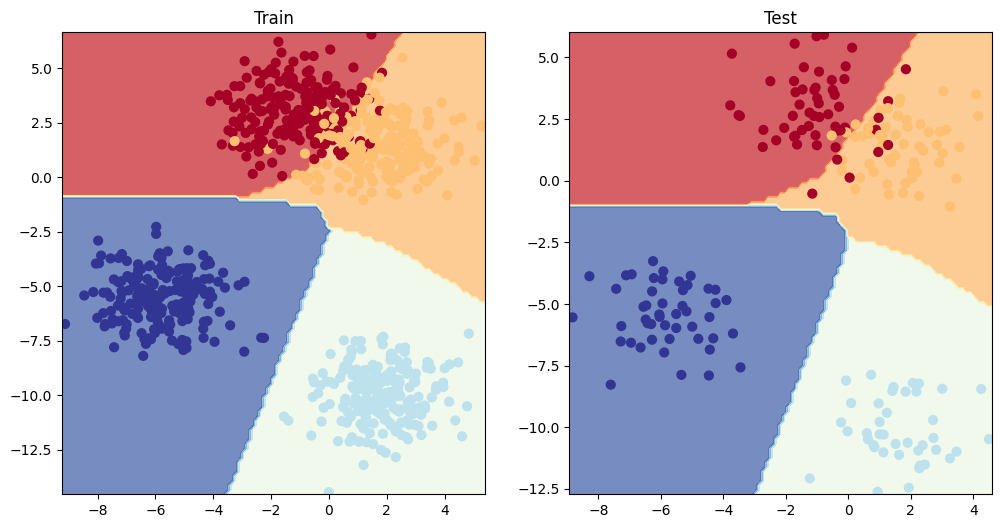

In [229]:
mymodel.eval()
with torch.inference_mode():
    y_logits = mymodel(X_test)
y_pred_probs = torch.softmax(y_logits, dim=1)

y_preds = y_pred_probs.argmax(dim=1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(mymodel, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(mymodel, X_test, Y_test)